Amplicon data of two different marker genes from the same samples
========


##### GPU functionality
* CUDA/NVDA GPU was loaded and functions 
* Mac ARM/metal GPU device is functional

##### Bayesian distributions
* Hamiltonian/MCMC/NUTS functionality working
* SVI (Machine learning) functionality working

##### Next
* Current model works for 16s PCs (6) and only 1 18s PC. Predicting a matrix looks straight forward for SVI/Machine learning Bayesian. 


### Import all the dependencies

In [110]:
import os
import pandas as pd
import numpy as np
import subprocess

In [111]:
import logging
import os

import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from torch.distributions import constraints

import pyro
import pyro.distributions as dist
import pyro.optim as optim

pyro.set_rng_seed(1)
assert pyro.__version__.startswith('1.8.4')

In [112]:
%matplotlib inline
plt.style.use('default')

logging.basicConfig(format='%(message)s', level=logging.INFO)
smoke_test = ('CI' in os.environ)
pyro.set_rng_seed(1)

In [153]:
import warnings
warnings.filterwarnings('ignore')

In [113]:
#Test for cuda devise
torch.cuda.get_device_name(0)

'Quadro T2000'

### Move to working directory

In [114]:
os.chdir("C:/Users/Kimani.Kimbrough/MarineDNA/Data")

## 01. This section imports the amplicon data sets as raw counts and calls an R script to model the ASV occurrences as probability distributions. 

#### Import amplicon data sheets as pandas dataframes and take a look

In [115]:
file1 = "Flyer2018_16S_table_counts.tsv"
file2 = "Flyer2018_18S_table_counts.tsv"
asvs1 = pd.read_csv(file1, index_col=0, sep="\t")
asvs2 = pd.read_csv(file2, index_col=0, sep="\t")

#### Run the function in a loop over both amplicon data sets and make a list of two data frames

## 02. Reduce dimensionality and visualize principal components

In [116]:
from sklearn.decomposition import PCA
import seaborn as sns

#### From untransformed matrices

In [117]:
df_16S = pd.read_csv('Flyer2018_16S_counts_modeled.tsv', index_col=0, sep="\t")
df_18S = pd.read_csv('Flyer2018_18S_counts_modeled.tsv', index_col=0, sep="\t")

In [118]:
df_16S_logodds = pd.read_csv('Flyer2018_16S_counts_modeled_logodds.tsv', index_col=0, sep="\t")
df_18S_logodds = pd.read_csv('Flyer2018_18S_counts_modeled_logodds.tsv', index_col=0, sep="\t")

In [119]:
df_18S_logodds.head(3)

,ASV_1,ASV_2,ASV_3,ASV_4,ASV_5,ASV_6,ASV_7,ASV_8,ASV_9,ASV_10,...,ASV_12597,ASV_12598,ASV_12599,ASV_12600,ASV_12605,ASV_12614,ASV_12622,ASV_12628,ASV_12632,ASV_12654
CN18Fc12_8_eDNA,-10.756859,-10.593197,-8.643773,-8.788970,-8.055674,-5.545171,-4.441849,-2.560170,-10.646872,-6.014757,...,-11.044271,-10.973521,-11.555774,-12.543974,-10.321654,-11.670656,-9.506807,-12.576215,-13.173169,-9.068835
CN18Fc19_5_eDNA,-9.610935,-10.697727,-9.834517,-1.237623,-8.055740,-5.750287,-5.297517,-3.497940,-13.273109,-9.819513,...,-13.529204,-11.586777,-10.274298,-10.539242,-10.442736,-12.820952,-11.339183,-11.542587,-11.175735,-9.599685
CN18Fc21_6_eDNA,-9.526299,-10.299450,-7.894128,-9.666646,-7.648044,-5.544435,-4.821070,-2.903922,-11.499101,-9.581033,...,-11.387652,-11.642321,-9.497081,-13.596958,-10.658010,-10.487587,-11.652703,-13.794406,-10.574365,-10.059448


#### From untransformed matrices

In [120]:
# Untransformed 16S
pca = PCA(n_components=62)
pca.fit_transform(df_16S)
variance_array_16S = np.cumsum(pca.explained_variance_ratio_ * 100)
#variance_array_16S

In [121]:
# Untransformed 18S
pca = PCA(n_components=62)
pca.fit_transform(df_18S)
variance_array_18S = np.cumsum(pca.explained_variance_ratio_ * 100)
#variance_array_18S

#### From log-odds transformed matrices

In [122]:
# Log-odds transformed 16S
pca = PCA(n_components=62)
pca.fit_transform(df_16S_logodds)
variance_array_16S_logodds = np.cumsum(pca.explained_variance_ratio_ * 100)
#variance_array_16S_logodds

In [123]:
# Log-odds transformed 18S
pca = PCA(n_components=62)
pca.fit_transform(df_18S_logodds)
variance_array_18S_logodds = np.cumsum(pca.explained_variance_ratio_ * 100)
#variance_array_18S_logodds

### Plot components vs variance explained

#### Based on the results above we will use the variances generated from the raw (untransformed) count probabilities

### Function to format variance numpy array for seaborn plot

In [124]:
def format_variance_data_for_plotting(variance_array):
    df = pd.DataFrame(variance_array, columns = ["Explained variance"])
    df = df.reset_index(level=0)
    df['index'] = df['index'] + 1
    df = df.rename(columns = {"index" : "Component number"})
    return(df)

#### Apply function to raw count probabilities

[Text(0.5, 1.0, 'Principal components of ASV count probabilities')]

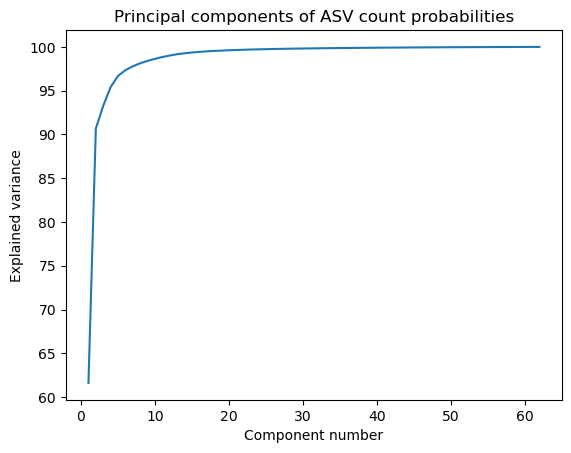

In [125]:
# 16S count data
df_variance = format_variance_data_for_plotting(variance_array_16S)
sns.lineplot(data=df_variance, x="Component number", 
             y="Explained variance").set(title='Principal components of ASV count probabilities') 

[Text(0.5, 1.0, 'Principal components of ASV count probabilities')]

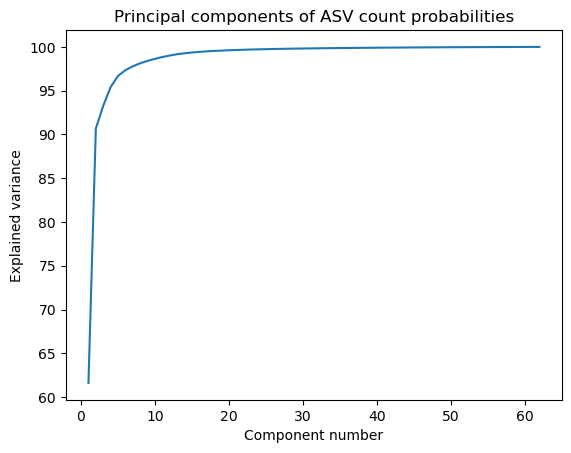

In [126]:
# 18S count data
df_variance = format_variance_data_for_plotting(variance_array_16S)
sns.lineplot(data=df_variance, x="Component number", 
             y="Explained variance").set(title='Principal components of ASV count probabilities') 

### Plot principal components of raw ASV count probabilities

[Text(0.5, 1.0, '16S PCA, raw count probabilities')]

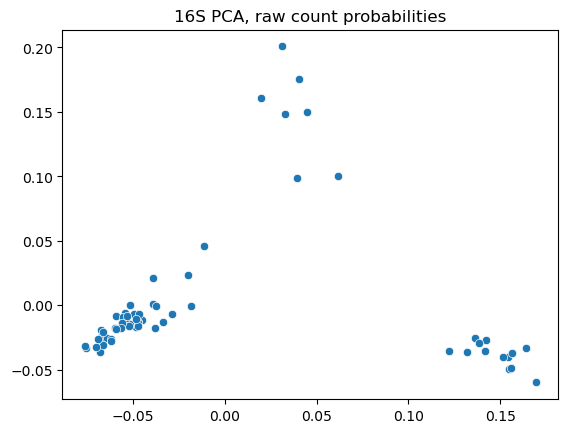

In [127]:
pca_16 = PCA(n_components=3)
pcs_16 = pca.fit_transform(df_16S)

pc1_values_16 = pcs_16[:,0]
pc2_values_16 = pcs_16[:,1]
sns.scatterplot(x=pc1_values_16, y=pc2_values_16).set(title="16S PCA, raw count probabilities")

[Text(0.5, 1.0, '18S PCA, raw count probabilities')]

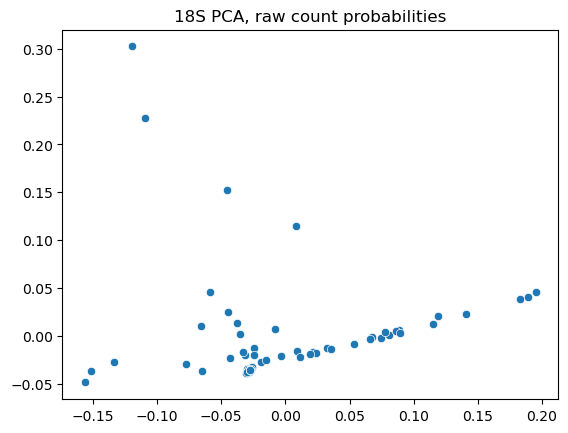

In [128]:
pca_118 = PCA(n_components=3)
pcs_18 = pca.fit_transform(df_18S)

pc1_values_18 = pcs_18[:,0]
pc2_values_18 = pcs_18[:,1]
sns.scatterplot(x=pc1_values_18, y=pc2_values_18).set(title="18S PCA, raw count probabilities")

## 03. Test the power of 16S data as a predictor for 18S data

### Function to extract defined number of PCs with sample labels

In [129]:
def extract_PCs_labeled(df_asvs_modeled, num_pcs):
    pca = PCA(n_components=num_pcs)
    pcs = pca.fit_transform(df_asvs_modeled)
    array = pcs[:, :num_pcs]
    cols = list()
    for i in range(1, num_pcs+1):
        n="PC%s" % i
        cols.append(n)
    df = pd.DataFrame(array, index=df_16S.index, columns = cols)
    return(df)

#### Export the first six PCs of the 16S data which explain 97% of the variance

In [130]:
pcs_16S = extract_PCs_labeled(df_16S, 6)
pcs_16S.to_csv("Flyer2018_16S_PCs.tsv", sep="\t")
pcs_16S

,PC1,PC2,PC3,PC4,PC5,PC6
CN18Fc12_8_eDNA,-0.020128,0.023832,-0.024139,0.038050,-0.016783,0.001938
CN18Fc19_5_eDNA,-0.075552,-0.033142,0.010200,-0.011909,0.003156,-0.002386
CN18Fc21_6_eDNA,-0.048505,-0.016760,-0.003077,0.003165,-0.006532,0.004679
CN18Fc22_6_eDNA,-0.066767,-0.022830,0.005425,-0.001503,-0.004624,0.003922
CN18Fc24_6_eDNA,-0.059178,-0.008103,-0.005169,0.006752,-0.001524,0.001449
...,...,...,...,...,...,...
CN18SESPkoa_SC42,0.131701,-0.035945,0.003022,-0.002341,-0.002827,0.002591
CN18SESPkoa_SC44,0.032810,0.148524,-0.005046,0.012712,-0.028669,-0.015435
CN18SESPkoa_SC45,0.141820,-0.035358,0.004186,0.004716,-0.003955,0.000039
CN18SESPkoa_SC47,0.136522,-0.025320,-0.000650,0.013615,-0.006447,-0.002134


#### Export the first two PCs of the 18S data for which we will test the 16S predictive power

In [131]:
pcs_18S = extract_PCs_labeled(df_18S, 2)
pcs_18S.to_csv("Flyer2018_18S_PCs.tsv", sep="\t")
pcs_18S

,PC1,PC2
CN18Fc12_8_eDNA,-0.018686,-0.027522
CN18Fc19_5_eDNA,-0.133394,-0.027902
CN18Fc21_6_eDNA,-0.031460,-0.019696
CN18Fc22_6_eDNA,-0.042921,-0.023416
CN18Fc24_6_eDNA,-0.151135,-0.036783
...,...,...
CN18SESPkoa_SC42,-0.026949,-0.034856
CN18SESPkoa_SC44,-0.029892,-0.037498
CN18SESPkoa_SC45,-0.027413,-0.035936
CN18SESPkoa_SC47,-0.027500,-0.036121


## Run Pyro linear model

In [134]:
print(pcs_16S.columns.values)

['PC1' 'PC2' 'PC3' 'PC4' 'PC5' 'PC6']


In [135]:
df1 = pcs_16S[['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6']]
df1.columns = ['pc1_values_16', 'pc2_values_16','pc3_values_16', 'pc4_values_16', 'pc5_values_16', 'pc6_values_16']
df2 = pcs_18S[['PC1']]
df2.columns = ['pc1_values_18']
df = pd.merge(df1, df2, left_index=True, right_index=True)

In [136]:
df

,pc1_values_16,pc2_values_16,pc3_values_16,pc4_values_16,pc5_values_16,pc6_values_16,pc1_values_18
CN18Fc12_8_eDNA,-0.020128,0.023832,-0.024139,0.038050,-0.016783,0.001938,-0.018686
CN18Fc19_5_eDNA,-0.075552,-0.033142,0.010200,-0.011909,0.003156,-0.002386,-0.133394
CN18Fc21_6_eDNA,-0.048505,-0.016760,-0.003077,0.003165,-0.006532,0.004679,-0.031460
CN18Fc22_6_eDNA,-0.066767,-0.022830,0.005425,-0.001503,-0.004624,0.003922,-0.042921
CN18Fc24_6_eDNA,-0.059178,-0.008103,-0.005169,0.006752,-0.001524,0.001449,-0.151135
...,...,...,...,...,...,...,...
CN18SESPkoa_SC42,0.131701,-0.035945,0.003022,-0.002341,-0.002827,0.002591,-0.026949
CN18SESPkoa_SC44,0.032810,0.148524,-0.005046,0.012712,-0.028669,-0.015435,-0.029892
CN18SESPkoa_SC45,0.141820,-0.035358,0.004186,0.004716,-0.003955,0.000039,-0.027413
CN18SESPkoa_SC47,0.136522,-0.025320,-0.000650,0.013615,-0.006447,-0.002134,-0.027500


In [137]:
def model(pc1_values_16, pc2_values_16, pc3_values_16, pc4_values_16, pc5_values_16, pc6_values_16, pc1_values_18):
    a = pyro.sample("a", dist.Normal(0., 100000.))
    b_PC1 = pyro.sample("b1", dist.Normal(0., 10000.))
    b_PC2 = pyro.sample("b2", dist.Normal(0., 10000.))
    b_PC3 = pyro.sample("b3", dist.Normal(0., 10000.))
    b_PC4 = pyro.sample("b4", dist.Normal(0., 10000.))
    b_PC5 = pyro.sample("b5", dist.Normal(0., 10000.))
    b_PC6 = pyro.sample("b6", dist.Normal(0., 10000.))
    sigma = pyro.sample("sigma", dist.Uniform(0., 10000.))

    mean = a + b_PC1 * pc1_values_16 + b_PC2 * pc2_values_16 + b_PC3 * pc3_values_16 + b_PC4 * pc4_values_16 + b_PC5 * pc5_values_16 + b_PC6 * pc6_values_16  

    with pyro.plate("data", len(pc6_values_16)):
        return pyro.sample("obs", dist.Normal(mean, sigma), obs=pc1_values_18)

In [156]:
from pyro.infer.autoguide import AutoMultivariateNormal, init_to_mean


guide = AutoMultivariateNormal(model, init_loc_fn=init_to_mean)

svi = SVI(model, 
          guide, 
          optim.Adam({"lr": .01}), 
          loss=Trace_ELBO())

pc1_values_16, pc2_values_16, pc3_values_16, pc4_values_16, pc5_values_16, pc6_values_16, pc1_values_18 = train[:, 0], train[:, 1], train[:, 2], train[:, 3], train[:, 4], train[:, 5], train[:, 6]
pyro.clear_param_store()
for i in range(num_iters):
    elbo = svi.step(pc1_values_16, pc2_values_16, pc3_values_16, pc4_values_16, pc5_values_16, pc6_values_16, pc1_values_18)
    if i % 500 == 0:
        logging.info("Elbo loss: {}".format(elbo))

Elbo loss: 658.8864908218384
Elbo loss: 340.38091135025024
Elbo loss: 95.62309551239014
Elbo loss: 9.439343452453613
Elbo loss: 11.31899356842041
Elbo loss: 10.59280776977539
Elbo loss: 10.457929611206055
Elbo loss: 9.505763053894043
Elbo loss: 11.26254653930664
Elbo loss: 10.792604446411133


In [157]:
# Utility function to print latent sites' quantile information.
def summary(samples):
    site_stats = {}
    for site_name, values in samples.items():
        marginal_site = pd.DataFrame(values)
        describe = marginal_site.describe(percentiles=[.05, 0.25, 0.5, 0.75, 0.95]).transpose()
        site_stats[site_name] = describe[["mean", "std", "5%", "25%", "50%", "75%", "95%"]]
    return site_stats

In [158]:
# Prepare training data
df4 = df[['pc1_values_16', 'pc2_values_16','pc3_values_16', 'pc4_values_16', 'pc5_values_16', 'pc6_values_16', 'pc1_values_18']]
df5 = df4[np.isfinite(df.pc1_values_18)]
train = torch.tensor(df5.values, dtype=torch.float)

In [159]:
from pyro.infer import SVI, Trace_ELBO


svi = SVI(model,
          guide,
          optim.Adam({"lr": .05}),
          loss=Trace_ELBO())

pc1_values_16, pc2_values_16, pc3_values_16, pc4_values_16, pc5_values_16, pc6_values_16, pc1_values_18 = train[:, 0], train[:, 1], train[:, 2], train[:, 3], train[:, 4], train[:, 5], train[:, 6]
pyro.clear_param_store()
num_iters = 5000 if not smoke_test else 2
for i in range(num_iters):
    elbo = svi.step(pc1_values_16, pc2_values_16, pc3_values_16, pc4_values_16, pc5_values_16, pc6_values_16, pc1_values_18)
    if i % 500 == 0:
        logging.info("Elbo loss: {}".format(elbo))

Elbo loss: 11.083145141601562
Elbo loss: 10.449831008911133
Elbo loss: 17.245811462402344
Elbo loss: 13.405051231384277
Elbo loss: 9.856602668762207
Elbo loss: 11.080595970153809
Elbo loss: 15.008257865905762
Elbo loss: 13.789142608642578
Elbo loss: 11.397547721862793
Elbo loss: 11.166792869567871


In [160]:
# Prepare training data
train = torch.tensor(df.values, dtype=torch.float)
#train

In [161]:
from pyro.infer import Predictive


num_samples = 1000
predictive = Predictive(model, guide=guide, num_samples=num_samples)
svi_samples = {k: v.reshape(num_samples).detach().cpu().numpy()
               for k, v in predictive(pc1_values_16, pc2_values_16, pc3_values_16, pc4_values_16, pc5_values_16, pc6_values_16, pc1_values_18).items()
               if k != "obs"}

In [151]:
from pyro.infer import MCMC, NUTS


nuts_kernel = NUTS(model)

mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=200)
mcmc.run(pc1_values_16, pc2_values_16, pc3_values_16, pc4_values_16, pc5_values_16, pc6_values_16, pc1_values_18)

hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}

Sample: 100%|██████████| 1200/1200 [01:19, 15.17it/s, step size=5.12e-01, acc. prob=0.922]


In [152]:
for site, values in summary(hmc_samples).items():
    print("Site: {}".format(site))
    print(values, "\n")

Site: a
       mean       std       5%       25%      50%       75%       95%
0 -0.000075  0.008943 -0.01471 -0.006276  0.00003  0.006199  0.014914 

Site: b1
       mean       std        5%       25%       50%       75%      95%
0 -0.252637  0.111176 -0.431323 -0.333933 -0.253662 -0.173477 -0.07019 

Site: b2
       mean       std        5%       25%       50%       75%       95%
0 -0.227261  0.171429 -0.514435 -0.346504 -0.228889 -0.108237  0.052122 

Site: b3
       mean       std        5%       25%       50%       75%       95%
0  0.438661  0.545961 -0.434789  0.063225  0.441626  0.787391  1.333655 

Site: b4
       mean       std        5%       25%       50%       75%      95%
0 -0.773184  0.630709 -1.854558 -1.203747 -0.755176 -0.346967  0.24937 

Site: b5
       mean       std        5%       25%       50%       75%       95%
0  0.813372  0.785239 -0.439813  0.312748  0.842729  1.369566  2.016237 

Site: b6
      mean       std        5%       25%       50%       75%       95%

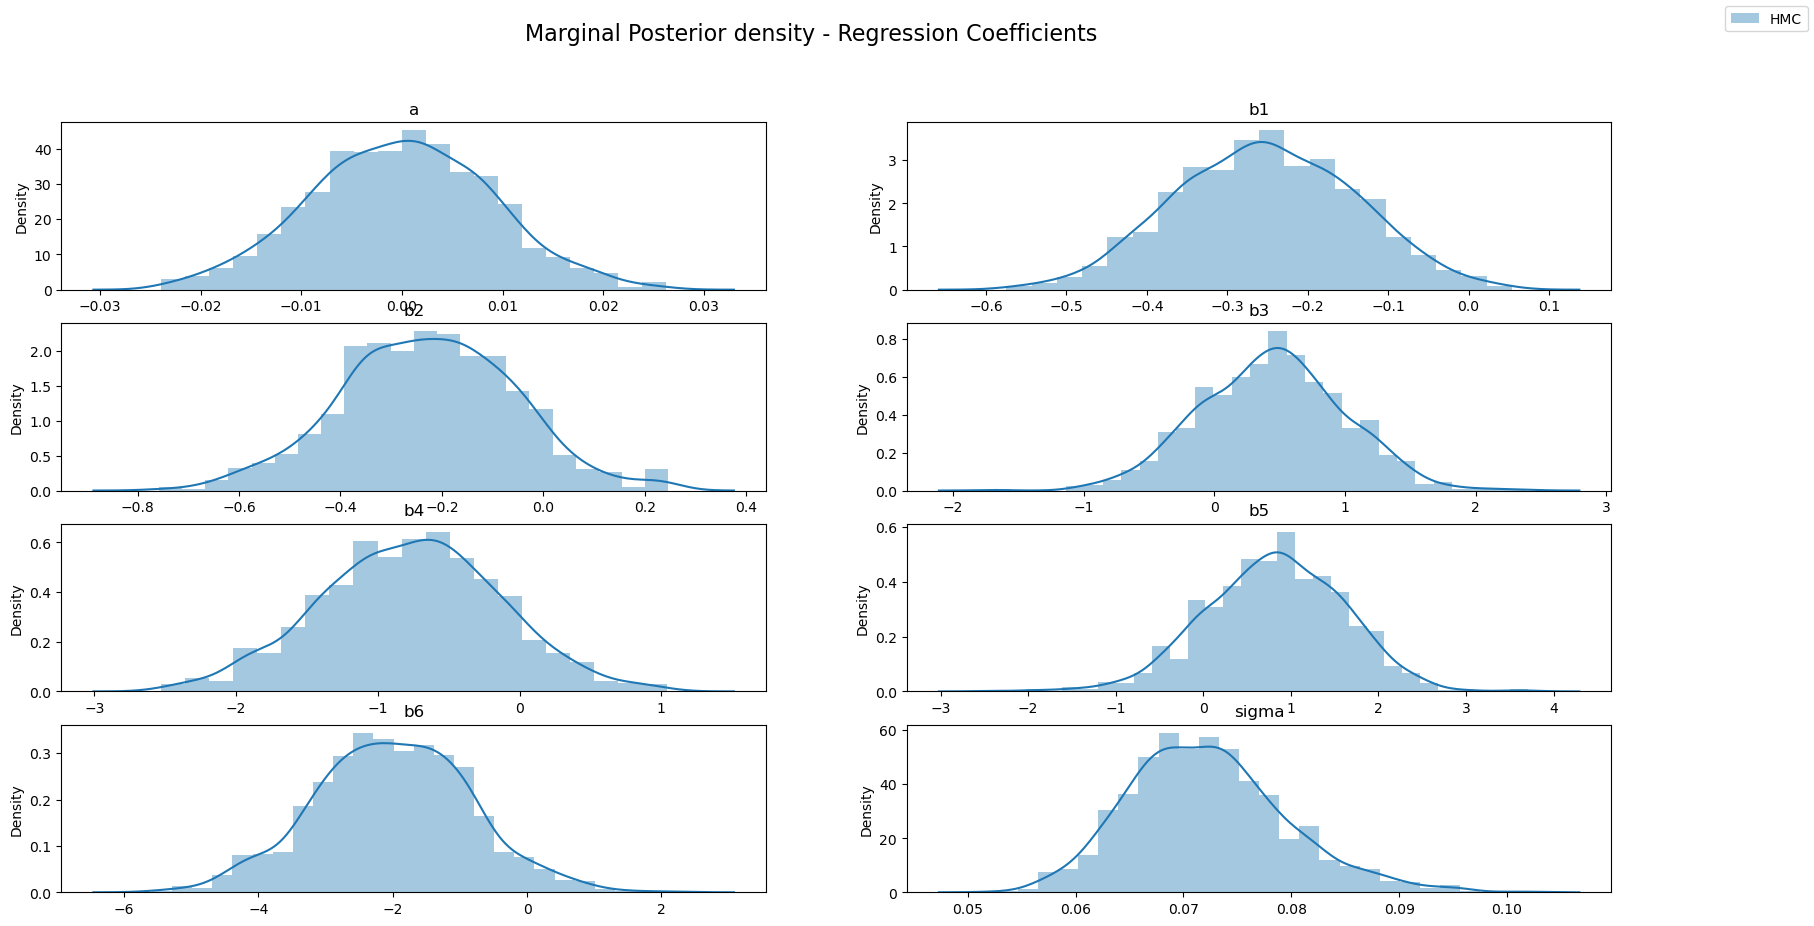

In [154]:
sites = ["a", "b1", "b2", "b3", "b4", "b5", "b6","sigma"]

fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(20, 10))
fig.suptitle("Marginal Posterior density - Regression Coefficients", fontsize=16)
for i, ax in enumerate(axs.reshape(-1)):
    site = sites[i]
    #sns.distplot(svi_samples[site], ax=ax, label="SVI (DiagNormal)")
    sns.distplot(hmc_samples[site], ax=ax, label="HMC")
    ax.set_title(site)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right');

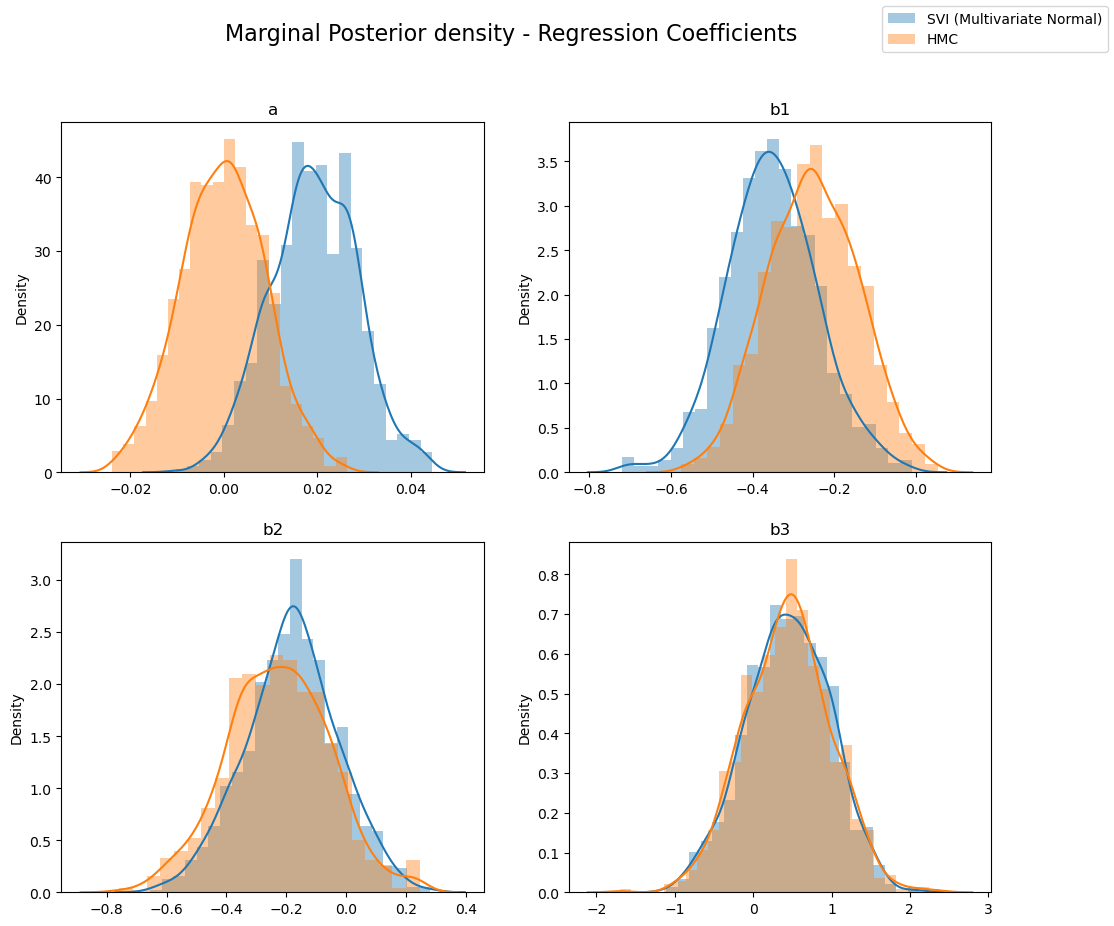

In [163]:
predictive = Predictive(model, guide=guide, num_samples=num_samples)
svi_mvn_samples = {k: v.reshape(num_samples).detach().cpu().numpy() 
                   for k, v in predictive(pc1_values_18, pc1_values_16, pc2_values_16, pc3_values_16, pc4_values_16, pc5_values_16, pc6_values_16).items()
                   if k != "obs"}
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
fig.suptitle("Marginal Posterior density - Regression Coefficients", fontsize=16)
for i, ax in enumerate(axs.reshape(-1)):
    site = sites[i]
    sns.distplot(svi_mvn_samples[site], ax=ax, label="SVI (Multivariate Normal)")
    sns.distplot(hmc_samples[site], ax=ax, label="HMC")
    ax.set_title(site)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right');